In [196]:
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
dataset = pd.read_csv('dataset.csv').iloc[:, 1:]

In [184]:
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [185]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [186]:
dataset = dataset[dataset['TotalCharges'] != ' ']

In [187]:
dataset['TotalCharges'] = dataset['TotalCharges'].astype(float)

In [188]:
dataset.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [35]:
categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()
numerical_columns = [col for col in dataset.columns if col not in categorical_columns]

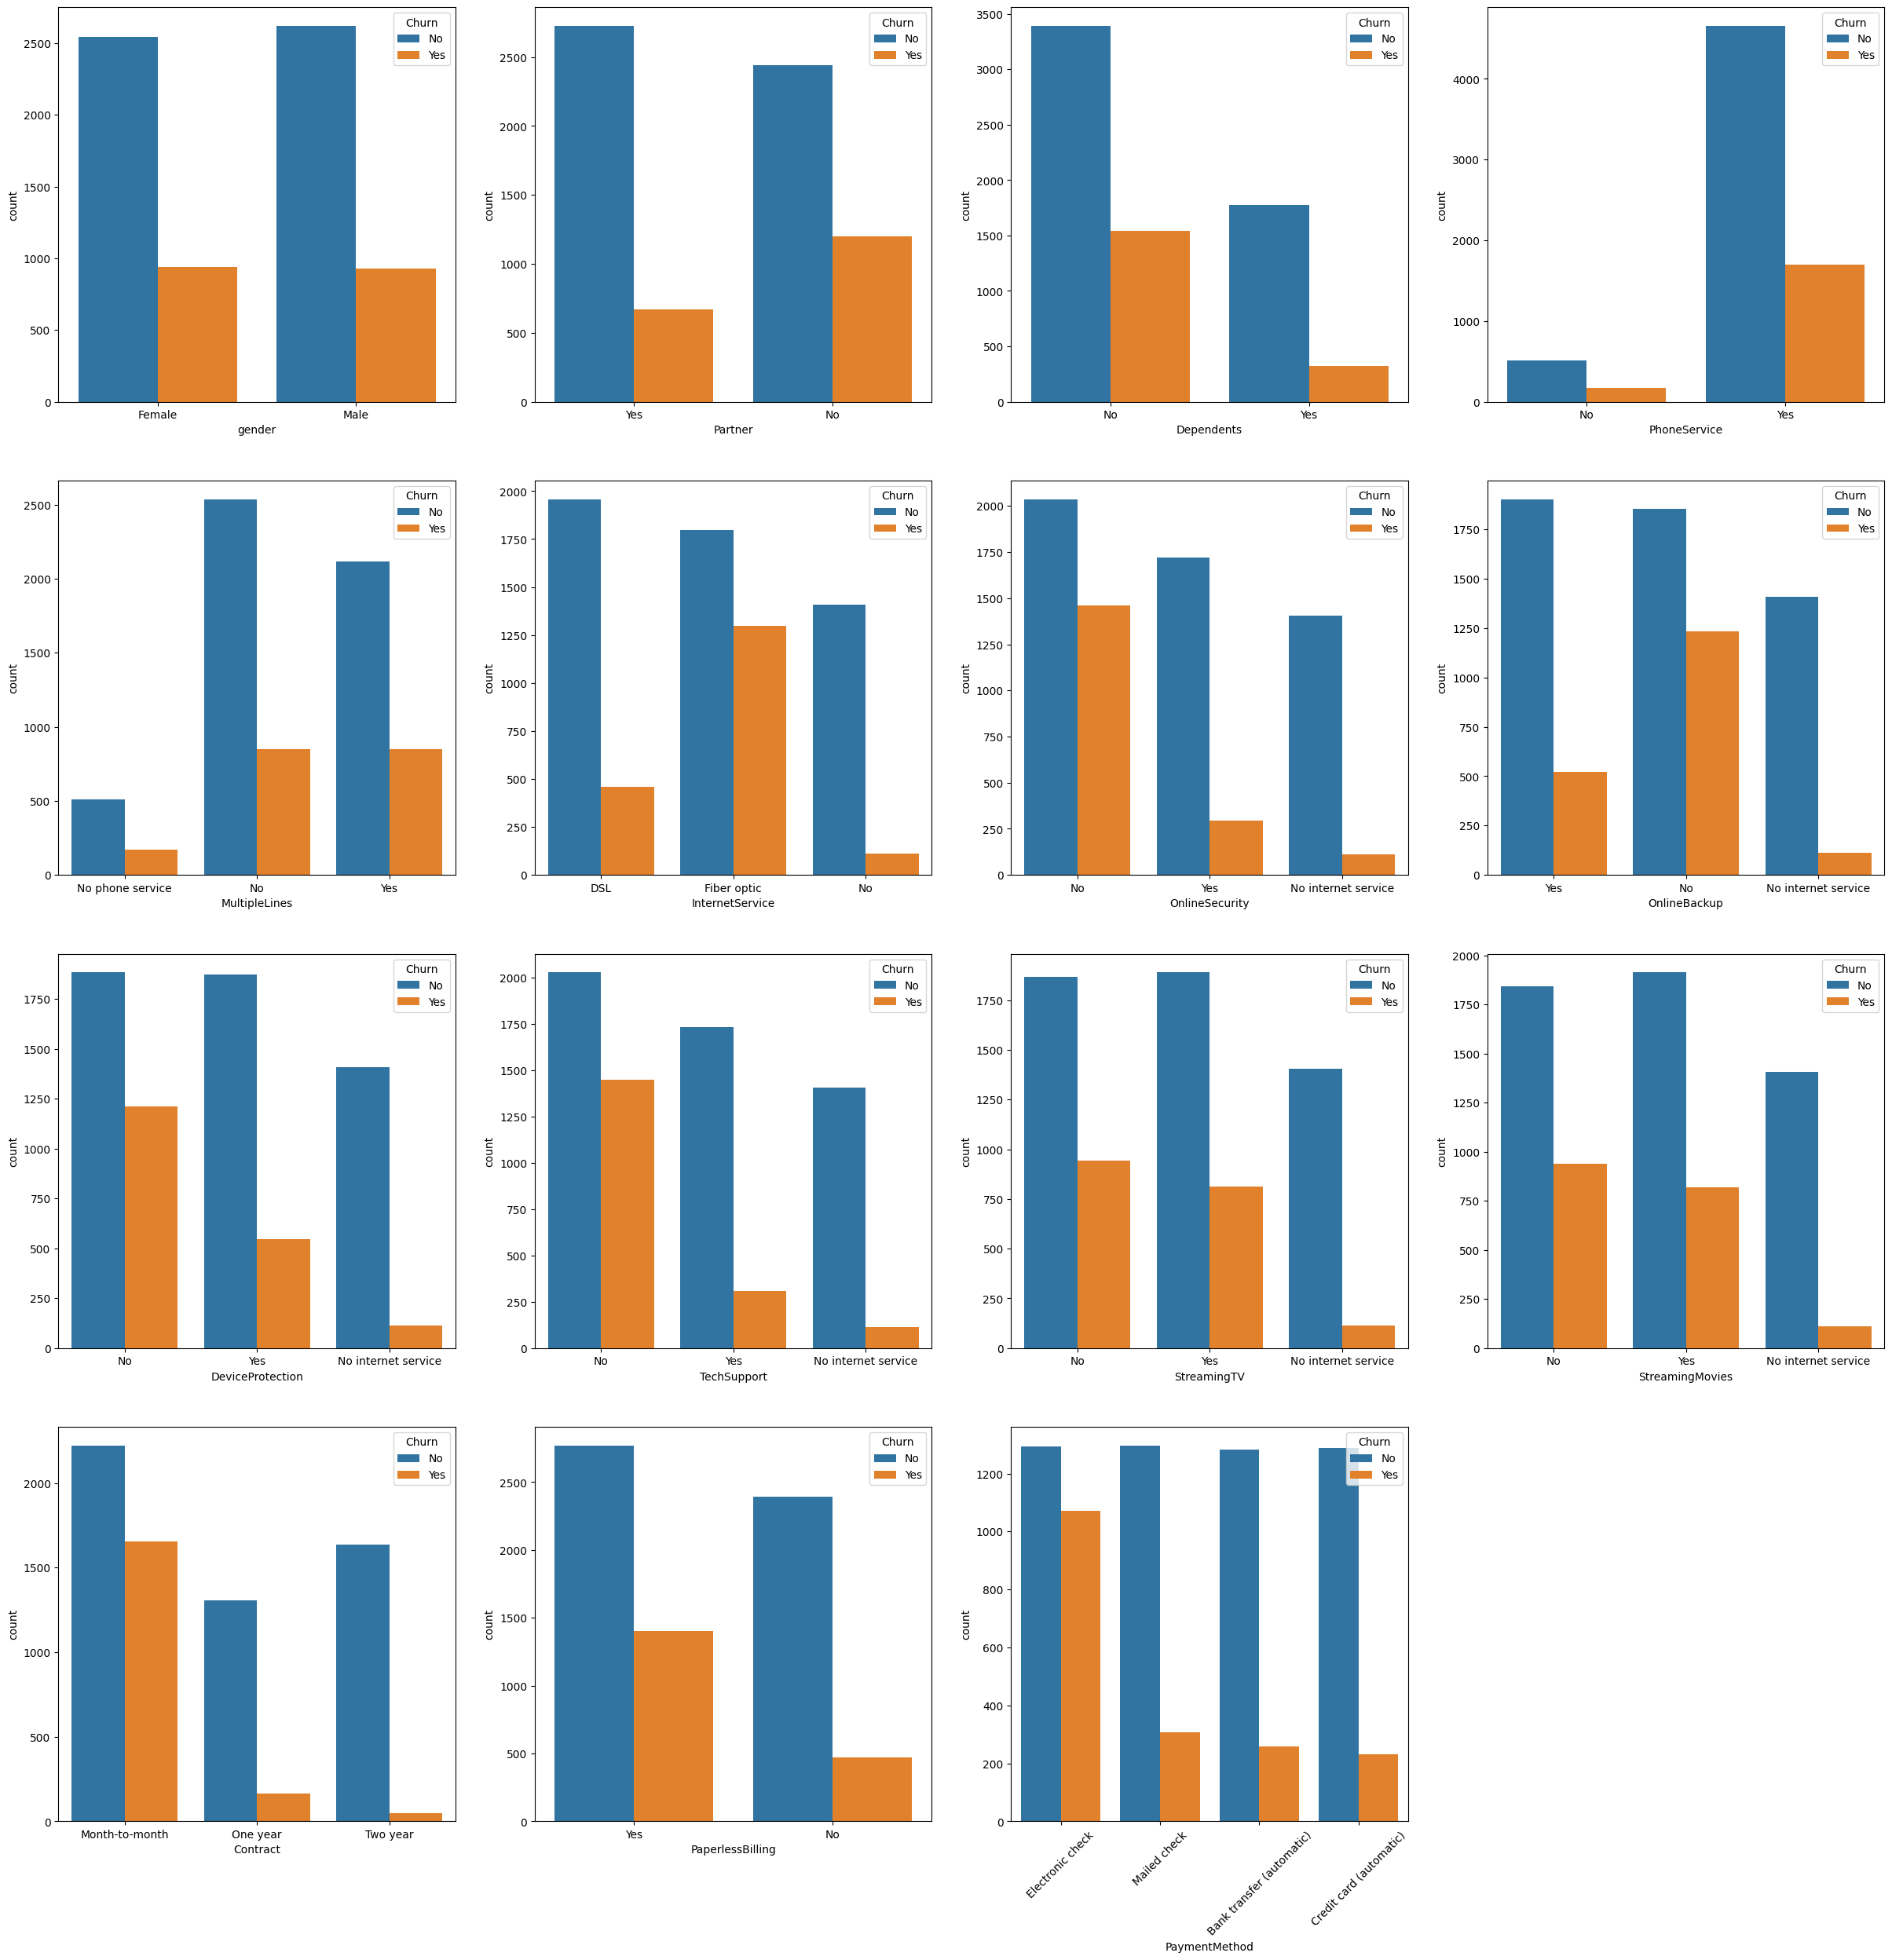

In [212]:
plt.figure(figsize=(30, 30))
for index, col in enumerate(categorical_columns):
    if col != 'Churn':
        plt.subplot(4, 4, index+1)
        sns.countplot(data=dataset, x=col, hue='Churn')
        if(len(dataset[col].unique()) > 3):
            plt.xticks(rotation=45)
plt.show()

In [228]:
len(numerical_columns)

4

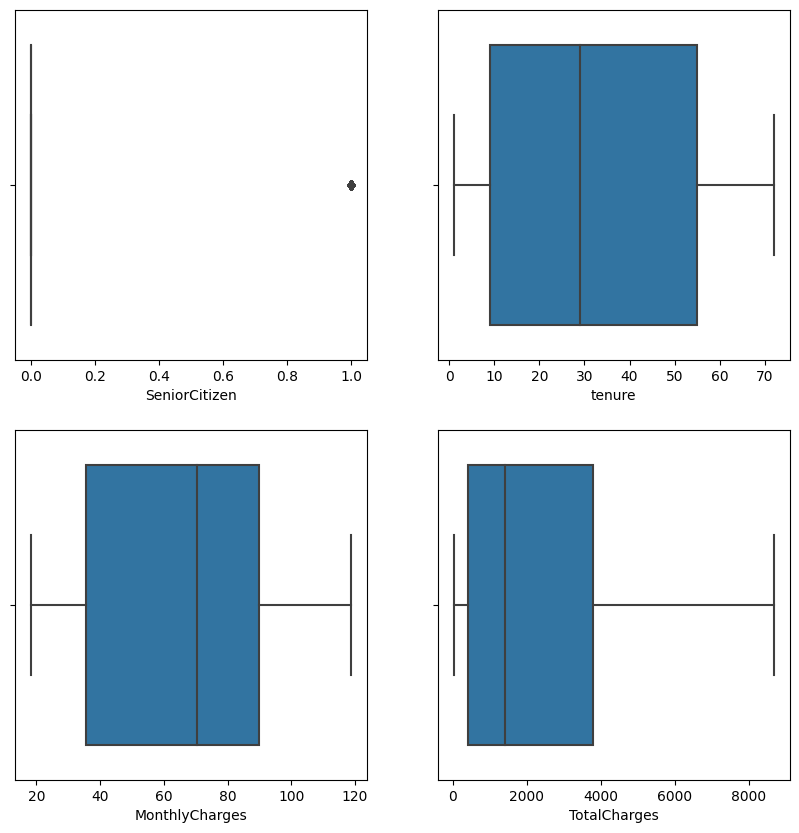

In [231]:
plt.figure(figsize=(10, 10))
for index, col in enumerate(numerical_columns):
    plt.subplot(2, 2, index+1)
    sns.boxplot(data=dataset, x=col)
plt.show()

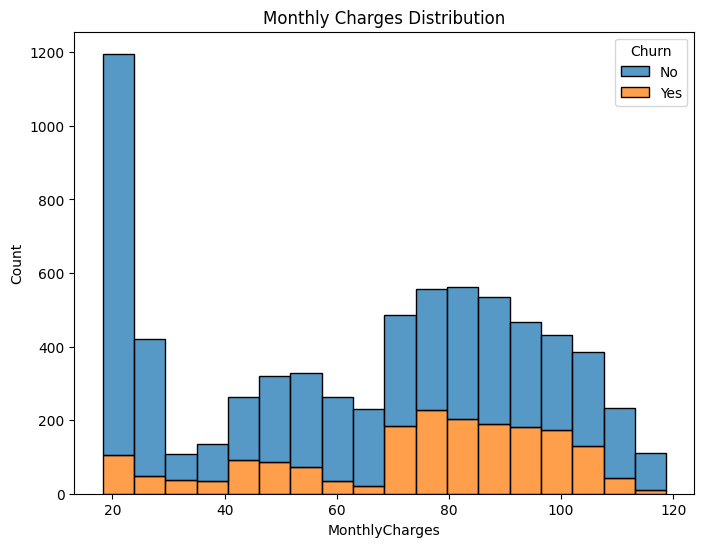

In [226]:
plt.figure(figsize=(8, 6))
sns.histplot(data=dataset, x='MonthlyCharges', hue='Churn', multiple='stack')
plt.title('Monthly Charges Distribution')
plt.show()

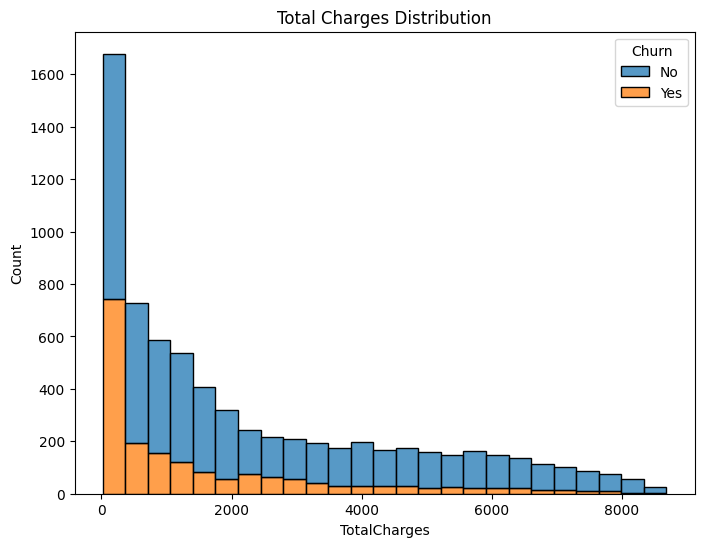

In [224]:
plt.figure(figsize=(8, 6))
sns.histplot(data=dataset, x='TotalCharges', hue='Churn', multiple='stack')
plt.title('Total Charges Distribution')
plt.show()

In [36]:
for col in categorical_columns:
    print(f'{col}: {dataset[col].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [37]:
dataset['MultipleLines'] = dataset['MultipleLines'].replace(to_replace='No phone service', value='No service')
dataset.loc[:, ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] = dataset.loc[:, ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].replace(to_replace='No internet service', value='No service')

In [38]:
categorical_columns_ordinal_1 = [
    'Partner',
    'Dependents',
    'PhoneService',
    'PaperlessBilling',
    'Churn'
]
categorical_columns_ordinal_2 = [
    'MultipleLines',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

In [39]:
ordinal_map_1 = {
    'Yes': 1,
    'No': 0
}
ordinal_map_2 = {
    'Yes': 1,
    'No': 0,
    'No service': -1
}
ordinal_map_3 = {
    'Fiber optic': 1,
    'DSL': 0,
    'No': -1
}
ordinal_map_4 = {
    'Two year': 2,
    'One year': 1,
    'Month-to-month': 0
}
ordinal_map_5 = {
    'Female': 1,
    'Male': 0
}

In [40]:
for col in categorical_columns_ordinal_1:
    dataset[col] = dataset[col].map(ordinal_map_1)

for col in categorical_columns_ordinal_2:
    dataset[col] = dataset[col].map(ordinal_map_2)

dataset['InternetService'] = dataset['InternetService'].map(ordinal_map_3)
dataset['Contract'] = dataset['Contract'].map(ordinal_map_4)
dataset['gender'] = dataset['gender'].map(ordinal_map_5)

In [41]:
km = KaplanMeierFitter()
cph = CoxPHFitter()

In [42]:
tenure = dataset['tenure']
churn = dataset['Churn']

<AxesSubplot: xlabel='timeline'>

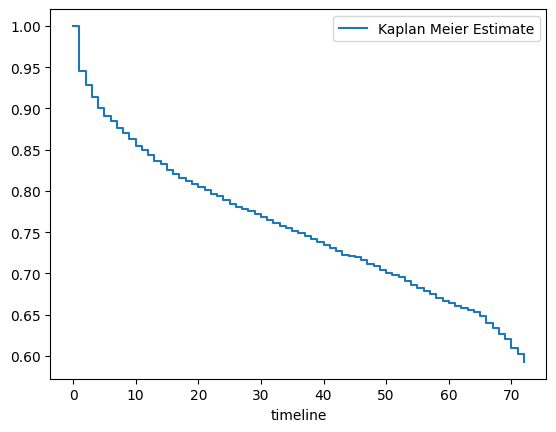

In [43]:
km.fit(tenure, churn,label='Kaplan Meier Estimate')
km.plot(ci_show=False)

In [44]:
# cph.fit(dataset, 'tenure', 'Churn')

In [45]:
# cph.print_summary()

In [46]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [47]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-3])], remainder='passthrough')
X = ct.fit_transform(X)

In [122]:
pd.get_dummies(dataset, columns=['PaymentMethod'], drop_first=True)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,-1,0,0,1,...,0,0,0,1,29.85,29.85,0,0,1,0
1,0,0,0,0,34,1,0,0,1,0,...,0,0,1,0,56.95,1889.50,0,0,0,1
2,0,0,0,0,2,1,0,0,1,1,...,0,0,0,1,53.85,108.15,1,0,0,1
3,0,0,0,0,45,0,-1,0,1,0,...,0,0,1,0,42.30,1840.75,0,0,0,0
4,1,0,0,0,2,1,0,1,0,0,...,0,0,0,1,70.70,151.65,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,0,1,0,...,1,1,1,1,84.80,1990.50,0,0,0,1
7039,1,0,1,1,72,1,1,1,0,1,...,1,1,1,1,103.20,7362.90,0,1,0,0
7040,1,0,1,1,11,0,-1,0,1,0,...,0,0,0,1,29.60,346.45,0,0,1,0
7041,0,1,1,0,4,1,1,1,0,0,...,0,0,0,1,74.40,306.60,1,0,0,1


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [50]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [136]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [100, 300, 500, 800, 1000],
        'max_depth': [10, 20, 30, None]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GaussianNB': {}
}

for key, value in models.items():
    grid_search = GridSearchCV(estimator=value, param_grid=param_grids[key],cv=10, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X=X_train, y=y_train)

In [137]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=1000)

In [155]:
random_forest_accuracy = grid_search.best_score_ * 100

In [156]:
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
y_pred = model.predict(X_test)
xgb_accuracy = accuracy_score(y_pred, y_test) * 100

/Users/ayushrajsingh/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [162]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32)

y_pred = model.predict(X_test) > 0.5
ann_accuracy = accuracy_score(y_pred, y_test) * 100

Epoch 1/100
176/176 [==============================] - 0s 604us/step - loss: 0.6275 - accuracy: 0.6720
Epoch 2/100
176/176 [==============================] - 0s 553us/step - loss: 0.4899 - accuracy: 0.7524
Epoch 3/100
176/176 [==============================] - 0s 556us/step - loss: 0.4566 - accuracy: 0.7673
Epoch 4/100
176/176 [==============================] - 0s 562us/step - loss: 0.4441 - accuracy: 0.7799
Epoch 5/100
176/176 [==============================] - 0s 588us/step - loss: 0.4353 - accuracy: 0.7838
Epoch 6/100
176/176 [==============================] - 0s 937us/step - loss: 0.4295 - accuracy: 0.7883
Epoch 7/100
176/176 [==============================] - 0s 676us/step - loss: 0.4250 - accuracy: 0.7906
Epoch 8/100
176/176 [==============================] - 0s 668us/step - loss: 0.4221 - accuracy: 0.7925
Epoch 9/100
176/176 [==============================] - 0s 673us/step - loss: 0.4195 - accuracy: 0.7950
Epoch 10/100
176/176 [==============================] - 0s 666us/step - l

In [163]:
accuracy_df = pd.DataFrame([[random_forest_accuracy, xgb_accuracy, ann_accuracy]], columns=['Random Forest', 'XGBoost', 'Artificial Neural Network'])

In [167]:
accuracy_df

,Random Forest,XGBoost,Artificial Neural Network
0,80.249047,79.81521,78.891258


array([80.24904711, 79.81520967, 78.891258  ])

<BarContainer object of 3 artists>

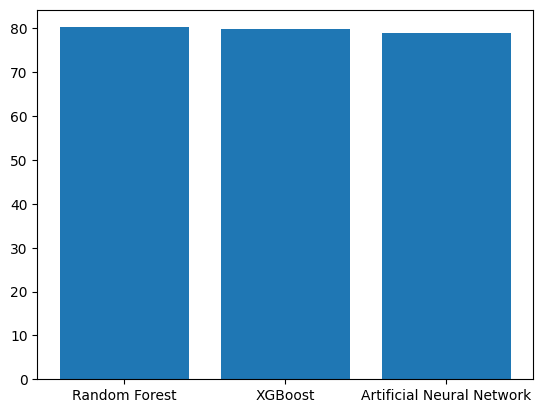

In [181]:
plt.bar(x=accuracy_df.columns, height=accuracy_df.iloc[0, :].values)